# CM 50270 Reinforcement Learning: Coursework 2 

**Date set:** March 12, 2018 

**Date due:** 8 pm on March 21, 2018 

**Total number of marks:** 100. (This coursework will determine 20% of your final grade for CM 50270.)

**What to submit:** Completed Jupyter notebook (.ipynb file) that includes all source code. Please do not change the file name.

**Where to submit:** CM50270 Moodle page

This coursework will be __marked anonymously__. Please do not include any identifying information on the files you submit. 

You are required to __work individually__. You are welcome to discuss ideas with others but you must design your own implementation and write your own code.

__Do not plagiarise__. Plagiarism is a serious academic offence. For details on what it is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.

Remember to save your work regularly. 

## Exercise 1: Blackjack (20 marks)

In this first exercise, you will implement **Monte Carlo Policy Evaluation (MCPE)** to learn the state-value function $V(s)$ for a given policy in the game of [blackjack](https://en.wikipedia.org/wiki/Blackjack).

### The game

**Rules.** We will use the version of the game discussed in the lectures where a single player (the agent) plays against the dealer. The player's objective is to obtain cards whose sum is as large as possible without exceeding 21. All face cards count as 10; an ace can count as either 1 or 11.

The game begins with two cards dealt to both the dealer and the player. The first of the dealer’s cards is face down and the second is face up. If the player has 21 immediately (for example, an ace and a face card), it is called a "blackjack". The player then wins unless the dealer also has a blackjack, in which case the game is a draw. If the player does not have a blackjack, then she can request additional cards, one by one (_hits_), until she either stops (_sticks_) or exceeds 21 (_goes bust_). If the player goes bust, she loses; if she sticks, then it becomes the dealer’s turn. 

The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome (win, lose, or draw) is determined by whose final sum is closer to 21.

**MDP formulation.** Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards until the end of the game are zero. We do not discount ($\gamma = 1$); therefore these terminal rewards are also the returns. The player’s actions are to `"hit"` or to `"stick"`. 

The states depend on the player’s cards and the dealer’s showing card. Assume that cards are dealt from an infinite deck (that is, with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that she could count as 11 without going bust, then the ace is said to be _usable_. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: 
- the player's current sum (an integer between 12 and 21);
- the dealer’s one showing card (an integer between 1 and 10; note that the ace is counted as 1 here); and
- whether or not the player holds a usable ace (a boolean). 

This makes for a total of 200 states. We represent the state as a numpy-array of length 3 that combines the just mentioned three variables in the given order. For example, if the player is given a 6 and a _jack_, and the dealer's showing card is an ace, the corresponding state will be the numpy array `[16, 1, False]`. The terminal state of the game will be denoted by the numpy array `[-1, -1, -1]`.

###  Blackjack code you may use if you wish

** Please feel free to skip this section and implement your own blackjack code **

We provide a `Blackjack` class that you can use to simulate blackjack games. The following cells in this section will walk you through the basic usage of this class by playing a couple of blackjack games.  

We import the blackjack module and create a blackjack environmnet called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the blackjack object will regularly print the progress of the game. This is useful for getting to know the game and the provided code or if you just want to play around. You may want to set `verbose=False` when you run thousands of episodes to complete the exercise below.

In [12]:
import blackjack
env = blackjack.Blackjack(verbose=True)

You can interact with the blackjack environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. Specifically, this method returns the resulting `new_state` and the corresponding `reward` signal.

Before the player can perform actions, we have to start the game (e.g., draw starting hands). In order to start or reset a blackjack game, call the `make_step()` without specifying a specific action or by setting `action="reset"`.

We will now walk through several example games. We will specify a [random seed](https://en.wikipedia.org/wiki/Random_seed) for the NumPy pseudo random number generator every time before we reset the game. This allows us to keep these examples reproducible.

In [13]:
import numpy as np
np.random.seed(8)
new_state, reward = env.make_step(action="reset")
print("Initial state:", new_state)
print("Reward:", reward)

The game is reset.
Player's cards: [10, 10]
Dealer's showing card: [7]
Initial state: [20  7  0]
Reward: 0


The player drew two cards with face value 10 each. The dealer also drew two cards, but we can only see the second card, a 7. The player now can choose to "hit" or "stick". Most players would stick if they had 20 on their hand. We call again the `make_step()` method and specify `action="stick"`.

In [14]:
new_state, reward = env.make_step(action = "stick")
print("The player obtains a reward of", reward)
print("The new (terminal) state is:", new_state)

The dealer's cards are: [10, 7]
The dealer has 17 points.
PLAYER WINS!
The player obtains a reward of 1
The new (terminal) state is: [-1 -1 -1]


The player won and received a reward of 1. Whenever an episode ends, the environment object sets the internal variable `self.active` to `False`. This variable is set to `True` again when we _reset_ the game. You can use the `self.active` variable to check whether an episode has ended or not.

In [15]:
np.random.seed(9)
new_state, reward = env.make_step(action="reset")
print("New state:", new_state)

The game is reset.
Player's cards: [11, 7]
Dealer's showing card: [2]
New state: [18  2  1]


The player has already 18 points but has a _usable ace_, which she can transfer into a 1 whenever she would _go bust_. The player can thus "hit" and hope that she gets closer to 21. 

In [16]:
new_state, reward = env.make_step(action = "hit")

Player draws card: [2]
New sum of player's cards: [20]


Great! The player got another 2 points and has again 20 points. The player would probably want to "stick" again...

In [17]:
new_state, reward = env.make_step(action = "stick")

The dealer's cards are: [7, 2]
The dealer has 9 points.
Dealer draws card: [3]
New dealer sum [12]
Dealer draws card: [6]
New dealer sum [18]
PLAYER WINS!


The player won again! Let's play a last one.

In [18]:
np.random.seed(7)
new_state, reward = env.make_step()
print("State", new_state)
print("Reward:", reward)

The game is reset.
Player's cards: [11, 10]
Dealer's showing card: [10]
Player has Blackjack!
The dealer's cards are: [6, 10]
PLAYER WINS!
State [-1 -1 -1]
Reward: 1


The player drew a "Blackjack", that is, an ace and a 10. The dealer's cards valued 16. The player won again and received a reward without having performed an action. Try out some more games to get familiar with the code!

### Instructions

Your task is to learn the state-value function for the policy **"Stick if the player's sum is 19 or higher, and hit otherwise."**. Your code should compute these state values using **Monte Carlo Policy Evaluation (MCPE)**. For your reference, the pseudo-code for MCPE is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 5.1).
<img src="images/MCPE.png" style="width: 400px;"/>
The provided pseudo-code shows _first-visit_ MCPE. No state occurs twice during one game (episode) of Blackjack. In this case, first-visit MCPE and every-visit MCPE are identical.

You will have to provide a function `get_state_value(s, v)` that takes as input a state `s` (a numpy array of length 3 as described in the MDP formulation of blackjack) and the state values `v` that you computed. The `get_state_value(s, v)` should return the correponding state value $V(s)$ as a float. There are no restrictions on how you store the state values `v`.

We will mark your code by calling `get_state_value(s, v)` for different states valid states `s` in the _test cell_.

In [51]:
# This cell should compute the state values 'v' using MCPE.
from blackjack import Blackjack
import numpy as np

# Creates a V table object
class V:

    def __init__(self):
        # Stores the 200 states in a dictionary, with a value and the amount of times its been visited in a tuple
        self.v_table = dict()

    def initialise_table(self):
        # Method initialises table to hold all 200 states with default values of (0,0)
        for ace in range(0, 2):
            for dealer in range(1, 11):
                for player in range(12, 22):
                    self.v_table.update({(player, dealer, ace): (0, 0)})

    def update_value(self, key, value, r):
        # Updates the value in the dictionary
        key = tuple(key)
        value_list = list(value)
        value_list[0] += r
        value_list[1] += 1
        value_tuple = tuple(value_list)
        self.v_table[key] = value_tuple

# Initialises environment and V tables
env = Blackjack(verbose=False)
v = V()
v.initialise_table()
episodes = 20000
policy = 19 # Sticks if players sum is 19 and above.

# Plays blackjack 'episodes' times.
for episode in range(1, episodes):
    done = False
    new_state, reward = env.make_step(action='reset')
    if (-1 in new_state) and (reward == 1):
        for i in range(2, 11):
            state = (21, i, 0)
            v.update_value(state, v.v_table[state], reward)
            done = True
    elif (-1 in new_state) and (reward == 0):
        state = (21, 1, 1)
        v.update_value(state, v.v_table[state], reward)
        done = True
    else:
        initial_state = new_state

    while not done:
        while 11 <= initial_state[0] < policy:
            new_state, reward = env.make_step(action="hit")
            if -1 in new_state:
                v.update_value(initial_state, v.v_table[tuple(initial_state)], reward)
                initial_state = new_state
                done = True
            else:
                initial_state = new_state
                v.update_value(initial_state, v.v_table[tuple(initial_state)], reward)
        if -1 in initial_state:
            done = True
            break
        else:
            new_state, reward = env.make_step(action="stick")
            v.update_value(initial_state, v.v_table[tuple(initial_state)], reward)
            done = True

In [52]:
# Function returns the state value, given the V object and the state
def get_state_value(s, v):
    value_tuple = v.v_table[s]
    value_list = list(value_tuple)
    if value_list[1] == 0:
        return 0.0
    else:
        state_value = value_list[0] / value_list[1]
    return state_value

states = v.v_table.keys()
for state in states:
    value = get_state_value(state, v)
    print("State: ", state, "Value: ", value)


State:  (12, 1, 0) Value:  -0.7397260273972602
State:  (13, 1, 0) Value:  -0.7435897435897436
State:  (14, 1, 0) Value:  -0.6818181818181818
State:  (15, 1, 0) Value:  -0.6470588235294118
State:  (16, 1, 0) Value:  -0.6735751295336787
State:  (17, 1, 0) Value:  -0.5580357142857143
State:  (18, 1, 0) Value:  -0.6206896551724138
State:  (19, 1, 0) Value:  0.01718213058419244
State:  (20, 1, 0) Value:  0.05121951219512195
State:  (21, 1, 0) Value:  0.3008130081300813
State:  (12, 2, 0) Value:  -0.7297297297297297
State:  (13, 2, 0) Value:  -0.6504854368932039
State:  (14, 2, 0) Value:  -0.6842105263157895
State:  (15, 2, 0) Value:  -0.6836158192090396
State:  (16, 2, 0) Value:  -0.6127450980392157
State:  (17, 2, 0) Value:  -0.6180257510729614
State:  (18, 2, 0) Value:  -0.6209150326797386
State:  (19, 2, 0) Value:  0.3069306930693069
State:  (20, 2, 0) Value:  0.43967828418230565
State:  (21, 2, 0) Value:  0.9139290407358739
State:  (12, 3, 0) Value:  -0.8
State:  (13, 3, 0) Value:  -0.6

In [21]:
# This is the TEST CELL for Exercise 1. We will use it to mark your solution. 
# All of your code for Exercise 1 must be written above this cell. 

## Exercise 2: Tic-Tac-Toe (80 marks)

In this exercise you will implement the game of [Tic-Tac-Toe](https://en.wikipedia.org/wiki/Tic-tac-toe) (also known as _noughts and crosses_) and learn an optimal policy using **Q-learning**. You will then implement **SARSA** and compare the two learning approaches with each other.

### The game

Tic-Tac-Toe is a paper-and-pencil game for two players, O and X, who take turns marking the spaces in a 3×3 grid. The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row wins the game. The following example game is won by player X (example from [Wikipedia](https://en.wikipedia.org/wiki/Tic-tac-toe)):
<img src="images/tic-tac-toe_WIKI.png" style="width: 600px;"/> 

### Instructions
Implement the game of Tic-Tac-Toe. The first-moving player is randomly chosen at the beginning of each episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero; do not discount ($\gamma = 1$). Player X will always be played by a _random agent_. This agent randomly chooses one of the empty grid spaces and marks it with "X". You will implement different agents for Player O.

We will ask you to plot your results and to discuss the produced plots. Please make sure to **label your figures appropriately**. Please only use plotting packages that come pre-installed with Anaconda 3. We recommend the package `matplotlib` (the tutorial provided in the first lab contains a whole section on matplotlib).

### Exercise 2a: Random policy against a random policy (10 marks)
Test your Tic-Tac-Toe implementation by letting two random agents play against each other. Plot the cumulative rewards of both O and X as a function of the number of episodes played. 

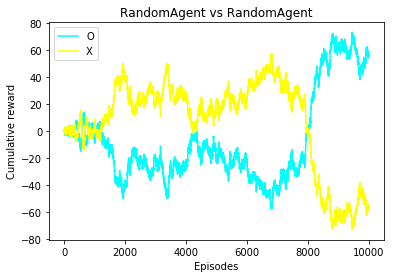

In [27]:
import numpy as np
import random as r
import matplotlib.pyplot as plt
%matplotlib inline


class Environment:

    def __init__(self):
        # The boards
        self.board = np.array([[" ", " ", " "],
                               [" ", " ", " "],
                               [" ", " ", " "]])
        
        self.reset = np.array([[" ", " ", " "],
                               [" ", " ", " "],
                               [" ", " ", " "]])
        # Counters
        self.counters = ["X", "O"]
        
        # Rewards
        self.win_reward = 1.0
        self.lose_reward = -1.0
        self.draw_reward = 0.0

    def first_mover(self):
        # Function to choose first mover
        if r.randint(0, 1) == 0:
            return "X"
        else:
            return "O"

    def get_available_actions(self, state):
        # Gets available actions given state
        actions = []
        for i in range(0, 3):
            for j in range(0, 3):
                if state[i][j] == " ":
                    cell = (i, j)
                    actions.append(cell)
        return actions

    def make_move(self, move, player):
        # Updates players move to the board
        self.board[move[0]][move[1]] = player.counter
        return self.board

    def check_winner(self, counter):
        # Check for winner horizontally
        for i in range(0, 3):
            row = self.board[i, :]
            count = np.count_nonzero(row == counter)
            if count == 3:
                return True

        # Check for winner vertically
        for j in range(0, 3):
            row = self.board[:, j]
            count = np.count_nonzero(row == counter)
            if count == 3:
                return True

        # Diagonal Check \
        count = 0
        for i in range(0, 3):
            if self.board[i][i] == counter:
                count += 1
        if count == 3:
            return True

        # Diagonal Check /
        count = 0
        for j in range(0, 3):
            if self.board[j][2 - j] == counter:
                count += 1
        if count == 3:
            return True
        
        return False

    def check_draw(self):
        # Checks to see if the board is in a draw
        for i in range(0, 3):
            for j in range(0, 3):
                if self.board[i][j] == " ":
                    return False
        return True

    def start_state(self, state):
        # Function used for finding optimal policy
        self.reset = np.copy(state)
        
    
    def reset_board(self):
        self.board = np.array([[" ", " ", " "],
                               [" ", " ", " "],
                               [" ", " ", " "]])


class RandomAgent:

    def __init__(self, environment, counter):
        self.environment = environment
        self.counter = counter
        self.cumulative_reward = 0
        self.reward_list = []

    def choose_action(self):
        actions = self.environment.get_available_actions(self.environment.board)
        action = r.choice(actions)
        return action
    
    def avg_reward(self, r):
        self.cumulative_reward += r
        self.reward_list.append(self.cumulative_reward)

# play function, with the environment, players and the number of episodes
def tictactoe(env, players, episodes=10000):
    # Iterates through each episode
    for episode in range(1, episodes + 1):

        # Resets the board
        env.reset_board()

        # Gets the player to go first.
        if env.first_mover() == "O":
            player = players[0]
            players[0] = players[1]
            players[1] = player

        # While game is not finished, keep playing
        finished = False
        while not finished:
            for player in players:
                action = player.choose_action()
                env.make_move(action, player)
                if env.check_winner(player.counter):
                    if players[0] == player:
                        player.avg_reward(env.win_reward)
                        players[1].avg_reward(env.lose_reward)
                    elif players[1] == player:
                        player.avg_reward(env.win_reward)
                        players[0].avg_reward(env.lose_reward)
                    finished = True
                    break
                elif env.check_draw():
                    players[0].avg_reward(env.draw_reward)
                    players[1].avg_reward(env.draw_reward)
                    finished = True
                    break
    return players[0].reward_list, players[1].reward_list

# Instantiates environment and both random players
environment = Environment()
counters = environment.counters
player_1 = RandomAgent(environment, counters[0])
player_2 = RandomAgent(environment, counters[1])

# Add the players to a list
players = []
players.append(player_1)
players.append(player_2)

# Returns lists of each players cumulative reward and then are plotted on a graph
line1 , line2 = tictactoe(environment, players)

x = np.arange(0, len(line1))

fig, (ax2) = plt.subplots(1,1)

ax2.plot(x, line1, color="cyan", label=players[0].counter)
ax2.plot(x, line2, color="yellow", label=players[1].counter)
ax2.set_title("RandomAgent vs RandomAgent")
ax2.set_xlabel('Episodes')
ax2.set_ylabel('Cumulative reward')

plt.legend()
plt.show()

![image.png](attachment:image.png)

I expected the graph to appear as it does. Agents are choosing randomly so there is no optimality when choosing moves, this makes the agents cumulative reward take large swings. Ultimately the graph is going to look different everytime you run it because of the randomness.

In a few sentences, discuss your results. Did you expect these results? Why or why not? (We will mark only the first three sentences. Please do not write any longer than that.) 



### Exercise 2b: Q-learning (20 marks)
Use Q-learning to learn an optimal policy for playing Tic-Tac-Toe against a random opponent. Produce a learning curve for your agent. That is, (1) plot average return as a function of episodes, (2) the learning curve should plot the average return of many agents (please specify how many agents you are averaging). 

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>
 

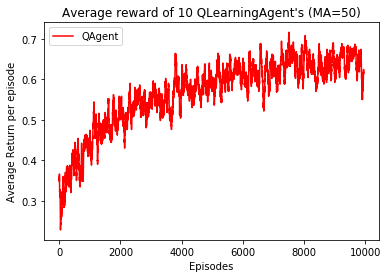

In [28]:
class QLearningAgent:

    def __init__(self, environment, counter, epsilon=0.05, gamma=1, alpha=0.1):
        self.environment = environment
        self.counter = counter
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha

        # Keeps track of overall reward
        self.cumulative_reward = 0
        self.reward_list = []

        # Q table and variables used for updating q values
        self.Q = {}
        self.last_state = None
        self.last_q_value = 0
        self.last_state_action = None

    def choose_action(self):
        
        # Get current state of the board
        current_state = tuple(self.environment.board.flatten())
        self.last_state = current_state
        actions = self.environment.get_available_actions(self.environment.board)

        # Greedy policy
        if np.random.uniform(0, 1) < self.epsilon:
            action = r.choice(actions)
            return action
        else:
            # Gets all state action pairs
            q_values = []
            for action in actions:
                q_values.append(self.get_q_values(current_state, action))
        
        max_q = max(q_values)
        count = q_values.count(max_q)
        
        # Checks to see if there is multiple max_q's.
        if count > 1:
            indexes = []
            for value in q_values:
                if value == max_q:
                    indexes.append(q_values.index(value))
            i = r.choice(indexes)
        else:
            i = q_values.index(max_q)
        
        self.last_state_action = (current_state, actions[i])
        self.last_q_value = self.get_q_values(self.last_state, actions[i])
        return actions[i]

    def update(self, initial_state, new_state, action, reward):
    
        # Get available actions for new_state
        actions = self.environment.get_available_actions(new_state)
        initial_state = tuple(initial_state.flatten())
        new_state = tuple(new_state.flatten())
        
        # Get Q values for state prime.
        q_values = []
        for action in actions:
            q_values.append(self.get_q_values(new_state, action))
        
        # Get max Q value of state prime
        if q_values:
            max_q = max(q_values)
        else:
            max_q = 0.0

        # Update Q(s, a) of last state    
        self.Q[self.last_state_action] = self.last_q_value + self.alpha * (reward + (self.gamma * max_q) - self.last_q_value)

    def get_q_values(self, s, a):
        if self.Q.get((s, a)) is None:
            self.Q[(s, a)] = 0.0
        return self.Q.get((s, a))

    def get_Q(self):
        return self.Q

# This was function was found online at: https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n     

# play function, with the environment, players and the number of episodes
def play_tictactoe(env, episodes=10000):
    
    counters = env.counters
    player_X = RandomAgent(env, counters[0])
    player_O = QLearningAgent(env, counters[1])
    average_reward = []
    
    # Iterates through each episodes
    for episode in range(1, episodes + 1):

        # Resets the board
        env.reset_board()

        # Gets a player to go first.
        x = env.first_mover()
        if x == "X":
            X_first = True
        else:
            X_first = False

        finished = False
        
        # While game is not finished, keep playing
        while not finished:
            if X_first:
                a = player_X.choose_action()
                new_state = env.make_move(a, player_X)
                X_first = False
            
            action = player_O.choose_action()
            initial_state = np.copy(env.board)
            new_state = env.make_move(action, player_O)
            
            if env.check_draw():
                reward = 0.0
                player_O.update(initial_state, new_state, action, reward)
                finished = True
                
            else:
                if env.check_winner(player_O.counter):
                    reward = 1.0
                    player_O.update(initial_state, new_state, action, reward)
                    finished = True
            
            if not finished:
                a = player_X.choose_action()
                new_state = env.make_move(a, player_X)

                if env.check_draw():
                    reward = 0.0
                    player_O.update(initial_state, new_state, action, reward)
                    finished = True
                else:
                    if env.check_winner(player_X.counter):
                        reward = -1.0
                        player_O.update(initial_state, new_state, action, reward)
                        finished = True
                    else:
                        reward = 0.0
                        player_O.update(initial_state, new_state, action, reward)
                        
        average_reward.append(reward)
    rewards = np.array(average_reward)
    rewards = moving_average(rewards, n=50)
    return rewards


# Play Tictactoe for 10000 episodes, 10 times. 
lines = []
for i in range(0, 10):
    
    # Instantiate environment        
    environment = Environment()
    
    # Returns average rewards and appends it to a list.
    line = play_tictactoe(environment)
    lines.append(line)

# Calculates average of the 10 Q learning agents, and then plots them onto a graph.
avg_line = []
for j in range(0, len(line)):
    avg = 0
    for line in lines:
        avg += line[j]
    avg = avg / len(lines)
    avg_line.append(avg)


x = np.arange(0, len(line))

fig, (ax2) = plt.subplots(1,1)

ax2.plot(x, avg_line, color="red", label="QAgent")
ax2.set_title("Average reward of 10 QLearningAgent's (MA=50)")
ax2.set_xlabel('Episodes')
ax2.set_ylabel('Average Return per episode')

plt.legend()
plt.show()

In 3 sentences or less, (1) explain the state representation you used, (2) discuss the learning curve you produced: 

![image.png](attachment:image.png)

I used a dictionary to store state action pairs with its value. Everytime a new state was discovered it would add it to the dictionary with value 0. The agent's average reward per epsiode increases over time, however does swing by around 0.2, this can be put down to the episilon value as sometimes it explores and chooses a random action. The QAgent learns quite quickly up to 2000 episodes then the rate slows down for the next 8000 but still continues to learn. (I used a moving average of 50 episodes, to even out the curve and stored an image of the result to save markers time).

### Exercise 2c: Optimal policy (20 marks)
What is the optimal play for the agent in the following state? You must answer by writing a function that takes a state as input and _prints_ the "after-state" that would result from playing an optimal action. The printed output can be primitive but the board has to be somewhat recognizable.   <img src="images/tic_tac_toe.png" style="width: 80px;"/> 

In [60]:
def optimal_tictactoe(env, state, episodes=20000):
    
    env.board = np.copy(env.reset)
    counters = env.counters
    player_X = RandomAgent(env, counters[0])
    player_O = QLearningAgent(env, counters[1])
    
    # Iterates through each episode
    for episode in range(1, episodes + 1):
        np.random.seed(2)
        # Resets the board
        start_board = np.copy(env.reset)
        env.board = np.copy(start_board)
        
        # While game is not finished, keep playing
        finished = False
        while not finished:
            action = player_O.choose_action()
            initial_state = np.copy(env.board)
            new_state = env.make_move(action, player_O)
            
            if env.check_draw():
                reward = 0.0
                player_O.update(initial_state, new_state, action, reward)
                finished = True
            else:
                if env.check_winner(player_O.counter):
                    reward = 1.0
                    player_O.update(initial_state, new_state, action, reward)
                    finished = True
            if not finished:
                a = player_X.choose_action()
                new_state = env.make_move(a, player_X)

                if env.check_draw():
                    reward = 0.0
                    player_O.update(initial_state, new_state, action, reward)
                    finished = True
                else:
                    if env.check_winner(player_X.counter):
                        reward = -1.0
                        player_O.update(initial_state, new_state, action, reward)
                        finished = True
                    else:
                        reward = 0.0
                        player_O.update(initial_state, new_state, action, reward)
    return player_O


def print_state(new_state):
    new_state = np.reshape(new_state, (3, 3))
    print(new_state[0][0] + " | " + new_state[0][1] + " | " + new_state[0][2])
    print("---------")
    print(new_state[1][0] + " | " + new_state[1][1] + " | " + new_state[1][2])
    print("---------")
    print(new_state[2][0] + " | " + new_state[2][1] + " | " + new_state[2][2])
        

def get_optimal_policy(state):
    
    # Instantiates environment and sets the start state as the state given in method.
    env = Environment()
    env.start_state(state)
    # Tictactoe function returns the QAgent so we can get access to Q values.
    QAgent = optimal_tictactoe(env, state)
    
    # Once Q agent is returned, it uses the Q agent's q values to choose where to go, and then will print out
    # the optimal move.
    actions = env.get_available_actions(state)
    q_values = []
    state = tuple(state.flatten())
    for action in actions:
        q_values.append(QAgent.get_q_values(state, action))
    max_q = max(q_values)
    i = q_values.index(max_q)
    
    state = np.reshape(state, (3, 3))
    state[actions[i]] = QAgent.counter
    print("Optimal move: ", actions[i])
    print_state(state)

board = np.array([["O", "X", " "],
                  [" ", "X", " "],
                  [" ", "O", " "]])

get_optimal_policy(board)

Optimal move:  (2, 0)
O | X |  
---------
  | X |  
---------
O | O |  


Please ignore this cell. We will use this cell to mark your answer. 


### Exercise 2d: Sarsa (40 marks)
Implement Sarsa to learn how to play Tic-tac-toe against a random player. Produce a learning curve. Also include the learning curve of your previously trained Q-learning agent in the same plot. Discuss the learning curves. For your reference, the pseudo-code for SARSA is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.4).
<img src="images/SARSA.png" style="width: 600px;"/>



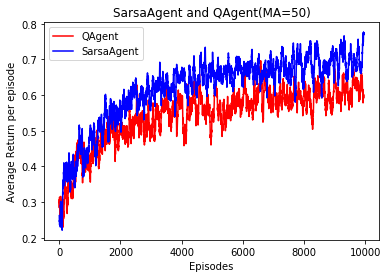

In [25]:
class SarsaAgent:

    def __init__(self, environment, counter, epsilon=0.05, gamma=1, alpha=0.1):
        self.environment = environment
        self.counter = counter
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha

        # Q table and variables used for updating q values
        self.Q = {}
        self.last_state = None
        self.last_action = None

    def choose_action(self, state):
        # Chooses action the same way as the Q learning agent.
        
        # Get current state of the board
        actions = self.environment.get_available_actions(state)
        state = tuple(state.flatten())
        
        # Greedy policy
        if np.random.uniform(0, 1) < self.epsilon:
            if actions:
                action = r.choice(actions)
                return action
            else:
                return (-1, -1)
        else:
            # Gets all state action pairs
            q_values = []
            for action in actions:
                q_values.append(self.get_q_values(state, action))
                
        if q_values:
            max_q = max(q_values)
            count = q_values.count(max_q)
            if count > 1:
                indexes = []
                for value in q_values:
                    if value == max_q:
                        indexes.append(q_values.index(value))
                i = r.choice(indexes)
            else:
                i = q_values.index(max_q)
            return actions[i]
        else:
            action = (-1, -1)
            return action
        
    def update(self, initial_state, state_prime, action, action_prime, reward):
    
        initial_state = tuple(initial_state.flatten())
        state_prime = tuple(state_prime.flatten())
        
        # Gets state action value of current state and action taken. 
        state_action_value = self.get_q_values(initial_state, action)
        
        # Get state prime value
        if action_prime == (-1, -1):
            state_prime_action_value = 0.0
        else:
            state_prime_action_value = self.get_q_values(state_prime, action_prime)
        
        # Update Q(s, a) of last state.
        self.Q[(initial_state, action)] = state_action_value + self.alpha * (reward + (self.gamma * state_prime_action_value) - state_action_value)
    
    def get_q_values(self, s, a):
        if self.Q.get((s, a)) is None:
            self.Q[(s, a)] = 0.0
        return self.Q.get((s, a))
    

# This function was found online at: https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n     

# play function, with the environment, players and the number of episodes
def play_tictactoe(env, episodes=10000):
    
    counters = env.counters
    player_X = RandomAgent(env, counters[0])
    player_O = SarsaAgent(env, counters[1])
    average_reward = []
    
    # Iterates through each episodes
    for episode in range(1, episodes + 1):
        
        # Resets the board
        env.reset_board()

        # Gets a player to go first.
        x = env.first_mover()
        if x == "X":
            X_first = True
        else:
            X_first = False

        if X_first:
            a = player_X.choose_action()
            new_state = np.copy(env.make_move(a, player_X))
            X_first = False
            
        initial_state = np.copy(env.board)
        action = player_O.choose_action(initial_state)
        player_O.last_state = initial_state
        player_O.last_action = action
        
        # While game is not finished, keep playing
        finished = False
        while not finished:
            initial_state = np.copy(env.board)
            action = player_O.last_action
            new_state = env.make_move(action, player_O)
            action_prime = (-1,-1)
            if env.check_draw():
                reward = 0.0
                player_O.update(initial_state, new_state, action, action_prime, reward)
                finished = True
                
            else:
                if env.check_winner(player_O.counter):
                    reward = 1.0
                    player_O.update(initial_state, new_state, action, action_prime, reward)
                    finished = True
            
            if not finished:
                a = player_X.choose_action()
                new_state = np.copy(env.make_move(a, player_X))
                action_prime = player_O.choose_action(new_state)

                if env.check_draw():
                    reward = 0.0
                    player_O.update(initial_state, new_state, action, action_prime, reward)
                    finished = True
                else:
                    if env.check_winner(player_X.counter):
                        reward = -1.0
                        player_O.update(initial_state, new_state, action, action_prime, reward)
                        finished = True
                    else:
                        reward = 0.0
                        player_O.update(initial_state, new_state, action, action_prime, reward)
                        player_O.last_action = action_prime
                        
        average_reward.append(reward)
    rewards = np.array(average_reward)
    rewards = moving_average(rewards, n=50)
    return rewards


# Plays Tictactoe 10000, 10 times. 
lines = []
for i in range(0, 10):
    
    # Instantiates environment and returns the average rewards and appends them to a list.     
    environment = Environment()
    line = play_tictactoe(environment)
    lines.append(line)

# Returns average of 10 sarsa agents.    
avg_line2 = []
for j in range(0, len(line)):
    avg = 0
    for line in lines:
        avg += line[j]
    avg = avg / len(lines)
    avg_line2.append(avg)

x = np.arange(0, len(line))

fig, (ax2) = plt.subplots(1,1)

ax2.plot(x, avg_line, color="red", label="QAgent")
ax2.plot(x, avg_line2, color="blue", label="SarsaAgent")
ax2.set_title("SarsaAgent and QAgent(MA=50)")
ax2.set_xlabel('Episodes')
ax2.set_ylabel('Average Return per episode')

plt.legend()
plt.show()

![image.png](attachment:image.png)

The graph shows that the Sarsa Agent has a better learning curve than the Q Agent. It learns at a similar rate up to about 1000 episodes, then sarsa gradually starts to acquire a better average return per episode. The Sarsa agent plateaus at around an average reward of 0.7 whereas the Q Agent plateaus at around 0.6. However, the QAgent does look to appear to converge with the Sarsa agent towards 10000, as it has taken time to catch up with the Sarsa agent's learning rate, which plateaus at about 8000 episodes. While Sarsa did produce a better result the curves are quite similar and both agents do look to eventually converge towards an optimal policy. This is because the algorithms are quite similar however the updates are different. Q learning assumes an optimal policy is being followed by picking an action by choosing the max q value of state prime, whereas sarsa picks action prime from the actual action it will take. Choosing a move with the actual policy means that the agent is less likley to take foolish actions as often, meaning the sarsa agent can learn faster. However, the end results after 10000 episodes is essentially the same. (Pre computed image of both agents is included if needed)